# References 
https://medium.com/the-research-nest/parking-space-detection-using-deep-learning-9fc99a63875e

In [ ]:
!git clone https://github.com/matterport/Mask_RCNN

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 33.39 MiB/s, done.
Resolving deltas: 100% (562/562), done.


In [ ]:
%tensorflow_version 1.15.


`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.15.`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [ ]:
import tensorflow as tf

print("Tensorflow Version: ", tf.__version__)

Tensorflow Version:  1.15.2


In [ ]:
import os
os.chdir("Mask_RCNN/")

import numpy as np
import cv2
import mrcnn.config
import mrcnn.utils
from mrcnn.model import MaskRCNN
from pathlib import Path
from google.colab.patches import cv2_imshow

from shapely.geometry import box
from shapely.geometry import Polygon as shapely_poly
from IPython.display import clear_output, Image, display, HTML
import io
import base64
%matplotlib inline
!apt-get install python3.8

!pip3 install pickle5
import pickle5 as pickle


Using TensorFlow backend.


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libpython3.8-minimal libpython3.8-stdlib python3.8-minimal
Suggested packages:
  python3.8-venv python3.8-doc binfmt-support
The following NEW packages will be installed:
  libpython3.8-minimal libpython3.8-stdlib python3.8 python3.8-minimal
0 upgraded, 4 newly installed, 0 to remove and 34 not upgraded.
Need to get 4,673 kB of archives.
After this operation, 18.5 MB of additional disk space will be used.
Get:1 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic/main amd64 libpython3.8-minimal amd64 3.8.10-1+bionic1 [762 kB]
Get:2 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic/main amd64 python3.8-minimal amd64 3.8.10-1+bionic1 [1,823 kB]
Get:3 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bioni

In [ ]:
class Config(mrcnn.config.Config):
    NAME = "coco_pretrained_model_config"
    IMAGES_PER_GPU = 1
    GPU_COUNT = 1
    NUM_CLASSES = 81

config = Config()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [ ]:
ROOT_DIR = Path(".")
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

In [ ]:
if not os.path.exists(COCO_MODEL_PATH):
    mrcnn.utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


In [ ]:
model = MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=Config())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [ ]:

model.load_weights(COCO_MODEL_PATH, by_name=True)

In [ ]:
#  This will contain test videos and images
if not os.path.exists("./data"):
    os.makedirs("./data")

left off here

> I'M OUT OF ROOM ON MY LAPTOP TO DOWNLOAD THE VIDEO TO UPLOAD IT HERE 



In [18]:
import os

cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print("Files in %r: %s" % (cwd, files))


Files in '/content/Mask_RCNN': ['mrcnn', 'samples', 'data', '.git', 'requirements.txt', 'setup.cfg', 'setup.py', 'assets', 'mask_rcnn_coco.h5', 'README.md', 'LICENSE', '.gitignore', 'images', 'MANIFEST.in']


In [27]:
VIDEO_SOURCE = "data/parking1.mp4"
PARKING_REGIONS = "data/regions1.p"
with open(PARKING_REGIONS, 'rb') as f:
    parked_car_boxes = pickle.load(f)

In [28]:
def get_car_boxes(boxes, class_ids):
    car_boxes = []

    for i, box in enumerate(boxes):
        # If the detected object isn't a car / truck, skip it
        if class_ids[i] in [3, 8, 6]:
            car_boxes.append(box)

    return np.array(car_boxes)

In [29]:
def compute_overlaps(parked_car_boxes, car_boxes):
    
    new_car_boxes = []
    for box in car_boxes:
        y1 = box[0]
        x1 = box[1]
        y2 = box[2]
        x2 = box[3]
        
        p1 = (x1, y1)
        p2 = (x2, y1)
        p3 = (x2, y2)
        p4 = (x1, y2)
        new_car_boxes.append([p1, p2, p3, p4])
    
    overlaps = np.zeros((len(parked_car_boxes), len(new_car_boxes)))
    for i in range(len(parked_car_boxes)):
        for j in range(car_boxes.shape[0]):
            pol1_xy = parked_car_boxes[i]
            pol2_xy = new_car_boxes[j]
            polygon1_shape = shapely_poly(pol1_xy)
            polygon2_shape = shapely_poly(pol2_xy)

            polygon_intersection = polygon1_shape.intersection(polygon2_shape).area
            polygon_union = polygon1_shape.union(polygon2_shape).area
            IOU = polygon_intersection / polygon_union
            overlaps[i][j] = IOU

    return overlaps

In [30]:
def arrayShow (imageArray):
    ret, png = cv2.imencode('.png', imageArray)
    encoded = base64.b64encode(png)
    return Image(data=encoded.decode('ascii'))

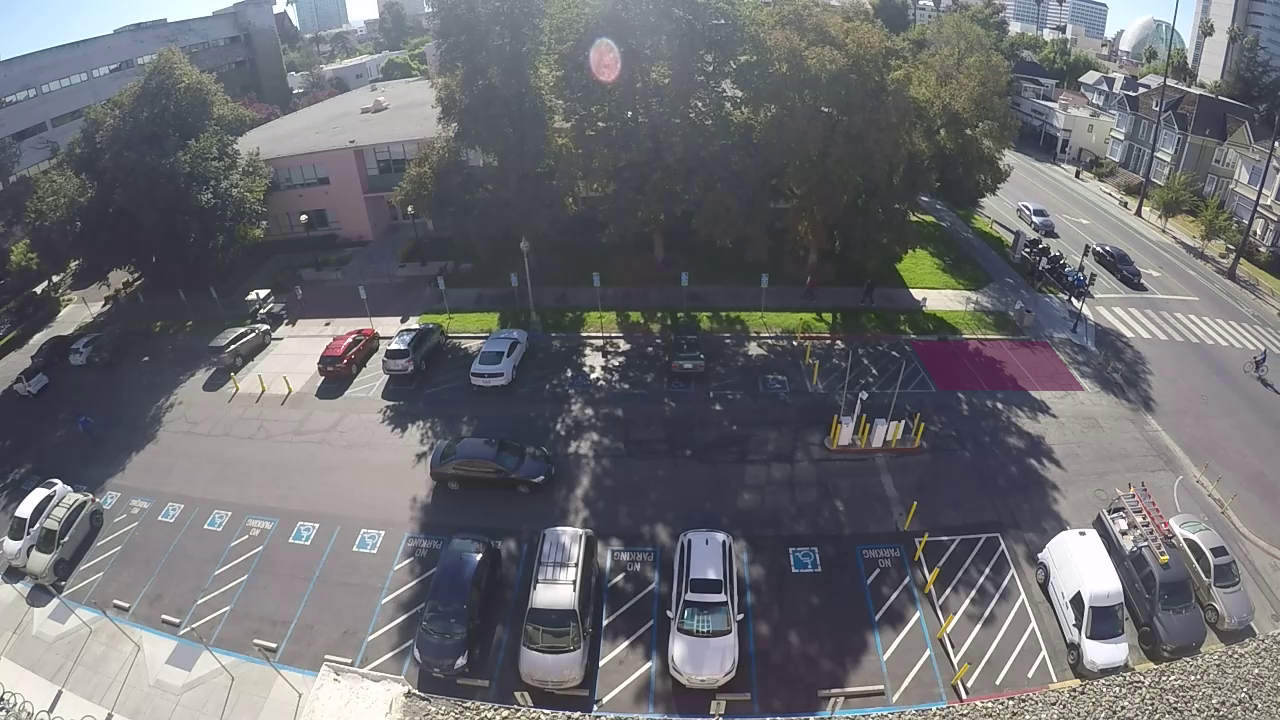

opened


KeyboardInterrupt: ignored

In [31]:
alpha = 0.6
video_capture = cv2.VideoCapture(VIDEO_SOURCE)
cnt=0

video_FourCC    = cv2.VideoWriter_fourcc('M','J','P','G')
video_fps       = video_capture.get(cv2.CAP_PROP_FPS)
video_size      = (int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH)),
                    int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT)))
print("video four", video_FourCC)
print("video size", video_size)
out = cv2.VideoWriter("out.avi", video_FourCC, video_fps, video_size)
print("out ", out)
print("asdfsdf")


while video_capture.isOpened():
    print("opened")
    success, frame = video_capture.read()
    overlay = frame.copy()
    if not success:
        print("failed")
        break

    rgb_image = frame[:, :, ::-1]
    results = model.detect([rgb_image], verbose=0)

    car_boxes = get_car_boxes(results[0]['rois'], results[0]['class_ids'])
    overlaps = compute_overlaps(parked_car_boxes, car_boxes)

    for parking_area, overlap_areas in zip(parked_car_boxes, overlaps):
        max_IoU_overlap = np.max(overlap_areas)
        if max_IoU_overlap < 0.15:
            cv2.fillPoly(overlay, [np.array(parking_area)], (71, 27, 92))
            free_space = True      
    cv2.addWeighted(overlay, alpha, frame, 1 - alpha, 0, frame)

    out.write(frame)

    clear_output(wait=True)
    img = arrayShow(frame)
    display(img)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        print("waiting")
        break

print("after while")
video_capture.release()
out.release()
cv2.destroyAllWindows()

In [26]:
print("video_fps", video_fps)

video_fps 0.0
